In [1]:
# importando os pacoteshttp://localhost:8888/notebooks/TCC_0323.ipynb#
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
import pandas as pd
print(pd.__version__)

1.4.2


In [2]:
# configuração da exibição
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# importando a base de treino (dados de 2017 até 2022)
df = pd.read_excel('leagues.xlsx')

In [4]:
df.dtypes

date                   datetime64[ns]
comp                           object
team                           object
opponent                       object
venue                          object
gf                              int64
ga                              int64
result                         object
Points last season_           float64
dtype: object

In [ ]:
#df = df[df['date']<= '2022-07-01']

In [5]:
# inserindo uma coluna com a pontuação obtida em cada partida
df['pont'] = df['result'].replace({'L': 0, 'D': 1, 'W':3})

In [6]:
# último resultado do confronto entre os times
# sort the DataFrame by date
df = df.sort_values(by='date')

# group the DataFrame by the home team and away team
grouped = df.groupby(['team', 'opponent'])

# create a new column that contains the sum of the last two results for each group
df['last_2_results_sum'] = grouped['pont'].apply(lambda x: x.rolling(2).sum().shift())

In [7]:
df.shape

(26270, 11)

In [8]:
def rolling_sum(group, cols, new_cols, venue):
    group = group.sort_values('date')
    group = group[group['venue'] == venue]
    rolling_stats = group[cols].rolling(3, closed='left').sum()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [9]:
df_rolling_home = df.groupby('team').apply(lambda x: rolling_sum(x, ['gf', 'ga', 'pont'], ['gf_rolling', 'ga_rolling', 'pont_rolling'], 'Home'))
df_rolling_home = df_rolling_home.droplevel('team')

In [10]:
df_rolling_away = df.groupby('team').apply(lambda x: rolling_sum(x, ['gf', 'ga', 'pont'], ['gf_rolling', 'ga_rolling', 'pont_rolling'], 'Away'))
df_rolling_away = df_rolling_away.droplevel('team')

In [11]:
# incluindo variáveis rolling do time jogando fora de casa
df_rolling = df_rolling_home.merge(df_rolling_away, left_on=['date', 'comp', 'opponent'], right_on=['date', 'comp', 'team'], suffixes=('_home','_away'), how='inner')

In [12]:
df_rolling = df_rolling[['date', 'comp', 'team_home', 'gf_rolling_home', 'ga_rolling_home', 'Points last season__home', 
                         'pont_rolling_home', 'last_2_results_sum_home',
                         'opponent_home', 'gf_rolling_away', 'ga_rolling_away', 'Points last season__away',
                         'pont_rolling_away', 'result_home']]

In [13]:
df_rolling.rename(columns={"team_home": "home", "opponent_home": "away", "result_home": "result", "last_2_results_sum_home": "last_2_results"}, inplace=True)

In [14]:
# substituindo valores do denominador do ratio que são 0 por 1, para não dar erro na divisão
df_rolling['pont_rolling_away'].replace(0, 1, inplace=True)
df_rolling['gf_rolling_away'].replace(0, 1, inplace=True)
df_rolling['ga_rolling_away'].replace(0, 1, inplace=True)

In [15]:
# inserindo coluna com a relação dos indicadores do time1 e time2
df_rolling['gf_rolling_ratio'] = df_rolling['gf_rolling_home']/df_rolling['gf_rolling_away']
df_rolling['ga_rolling_ratio'] = df_rolling['ga_rolling_home']/df_rolling['ga_rolling_away']
df_rolling['points_last_season_ratio'] = df_rolling['Points last season__home']/df_rolling['Points last season__away']
df_rolling['pont_rolling_ratio'] = df_rolling['pont_rolling_home']/df_rolling['pont_rolling_away']

In [16]:
df_rolling.head()

,date,comp,home,gf_rolling_home,ga_rolling_home,Points last season__home,pont_rolling_home,last_2_results,away,gf_rolling_away,ga_rolling_away,Points last season__away,pont_rolling_away,result,gf_rolling_ratio,ga_rolling_ratio,points_last_season_ratio,pont_rolling_ratio
0,2022-09-11,Ligue 1,Ajaccio,1.0,4.0,37.5,1.0,NaN,Nice,3.0,3.0,66.0,4.0,L,0.333333,1.333333,0.568182,0.25
1,2022-10-02,Ligue 1,Ajaccio,1.0,5.0,37.5,0.0,NaN,Clermont Foot,1.0,3.0,36.0,1.0,L,1.000000,1.666667,1.041667,0.00
2,2022-11-05,Ligue 1,Ajaccio,1.0,7.0,37.5,0.0,NaN,Strasbourg,6.0,6.0,63.0,4.0,W,0.166667,1.166667,0.595238,0.00
3,2022-12-28,Ligue 1,Ajaccio,5.0,8.0,37.5,3.0,NaN,Angers,2.0,6.0,41.0,1.0,W,2.500000,1.333333,0.914634,3.00
4,2023-01-11,Ligue 1,Ajaccio,5.0,5.0,37.5,6.0,NaN,Reims,2.0,2.0,46.0,3.0,L,2.500000,2.500000,0.815217,2.00


In [17]:
df_rolling = df_rolling[['date', 'comp', 'home', 'away', 'result', 'last_2_results', 'gf_rolling_ratio', 'ga_rolling_ratio', 'points_last_season_ratio',
                        'pont_rolling_ratio']]

In [18]:
df_rolling.shape

(12413, 10)

In [19]:
df_rolling = df_rolling[~df_rolling['last_2_results'].isna()]

In [20]:
df_rolling.shape

(8834, 10)

In [21]:
# verificando valores missing
df_rolling.isna().sum().sort_values(ascending=False)

date                        0
comp                        0
home                        0
away                        0
result                      0
last_2_results              0
gf_rolling_ratio            0
ga_rolling_ratio            0
points_last_season_ratio    0
pont_rolling_ratio          0
dtype: int64

In [22]:
# verificando se há linhas duplicadas na base
df_rolling.duplicated().unique()

array([False])

In [23]:
# criando a coluna 'target' --> Vitóra = 1, Não vitória = 0

conditions = [df_rolling['result'] == 'W', df_rolling['result'] == 'D', df_rolling['result'] == 'L']
    
values = [1, 0, 0]
    
df_rolling['target'] = np.select(conditions, values)

In [24]:
df_rolling['result'].value_counts()

W    3868
L    2690
D    2276
Name: result, dtype: int64

In [25]:
df_rolling.corr()['target']

last_2_results              0.170861
gf_rolling_ratio            0.139447
ga_rolling_ratio           -0.114479
points_last_season_ratio    0.286636
pont_rolling_ratio          0.142620
target                      1.000000
Name: target, dtype: float64

### Como o objetivo é predizer qual time tem mais chance de saír vencedor, vamos considerar apenas as partidas onde houve um vencedor. Por esse motivo, vamos excluir os empates da base.

In [26]:
df_rolling = df_rolling[df_rolling['result'] != 'D']

In [27]:
# filtrando as colunas que serão utilizadas
df_ml = df_rolling[['date', 'home', 'away', 'gf_rolling_ratio', 'ga_rolling_ratio',
                    'points_last_season_ratio', 
                    'pont_rolling_ratio',
                    'result', 'last_2_results', 'target']]

In [28]:
df_ml['target'].value_counts()

1    3868
0    2690
Name: target, dtype: int64

In [29]:
df_ml['target'].value_counts(normalize=True)

1    0.589814
0    0.410186
Name: target, dtype: float64

In [30]:
df_ml

,date,home,away,gf_rolling_ratio,ga_rolling_ratio,points_last_season_ratio,pont_rolling_ratio,result,last_2_results,target
32,2018-09-02,Alaves,Espanyol,0.750000,2.000000,0.959184,0.571429,W,4.0,1
34,2018-10-06,Alaves,Real Madrid,0.600000,0.400000,0.618421,1.250000,W,0.0,1
35,2018-10-28,Alaves,Villarreal,0.800000,0.666667,0.770492,1.166667,W,3.0,1
39,2019-01-05,Alaves,Valencia,1.500000,0.666667,0.643836,1.250000,W,0.0,1
41,2019-02-11,Alaves,Levante,2.000000,0.250000,1.021739,4.000000,W,3.0,1
...,...,...,...,...,...,...,...,...,...,...
12407,2023-03-18,Wolverhampton Wanderers,Leeds United,2.000000,0.250000,1.342105,6.000000,L,0.0,0
12408,2023-04-08,Wolverhampton Wanderers,Chelsea,0.750000,1.250000,0.689189,0.750000,W,1.0,1
12409,2023-04-15,Wolverhampton Wanderers,Brentford,0.800000,1.000000,1.108696,1.500000,W,4.0,1
12410,2023-04-25,Wolverhampton Wanderers,Crystal Palace,0.625000,0.800000,1.062500,1.000000,W,0.0,1


In [31]:
# separando a base em treino e teste
from sklearn.model_selection import train_test_split

train_size=0.85

X = df_ml.drop(columns = ['target', 'result', 'date', 'home', 'away']).copy()
y = df_ml['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=train_size, random_state=20)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(5574, 5)
(5574,)
(984, 5)
(984,)


(None, None)

In [32]:
y_train.value_counts(normalize=True)

1    0.591676
0    0.408324
Name: target, dtype: float64

In [33]:
y_test.value_counts(normalize=True)

1    0.579268
0    0.420732
Name: target, dtype: float64

# Modelos de Machine Learning

In [34]:
# Função para trazer as medidas
def medidas(y_test, y_pred_best):
    print(f'precision:{precision_score(y_test, y_pred_best):.2f}')
    print(f'accuracy:{accuracy_score(y_test, y_pred_best):.2f}')
    print(f'recall:{recall_score(y_test, y_pred_best):.2f}')
    print(f'f1_score:{f1_score(y_test, y_pred_best):.2f}')
    print(f'roc_auc_score:{roc_auc_score(y_test, y_pred_best):.2f}')

## Regressão Logística

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

In [36]:
X_train.columns

Index(['gf_rolling_ratio', 'ga_rolling_ratio', 'points_last_season_ratio',
       'pont_rolling_ratio', 'last_2_results'],
      dtype='object')

In [37]:
std_scaller = [('numeric_scaler', SklearnTransformerWrapper(variables=['gf_rolling_ratio', 'ga_rolling_ratio', 'points_last_season_ratio',
                                                                       'pont_rolling_ratio',
                                                                       'last_2_results'], transformer=StandardScaler()))]

pipeline = Pipeline(steps= std_scaller + [('logit', LogisticRegression())])

In [38]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('logit', LogisticRegression())])

In [39]:
y_pred = pipeline.predict(X_test)

In [40]:
precision_score(y_test, y_pred)

0.702660406885759

In [41]:
accuracy_score(y_test, y_pred)

0.6839430894308943

In [42]:
recall_score(y_test, y_pred)

0.787719298245614

In [43]:
f1_score(y_test, y_pred)

0.7427626137303556

In [44]:
roc_auc_score(y_test, y_pred)

0.6643910500889906

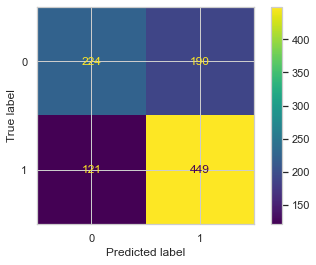

In [45]:
plot_confusion_matrix(pipeline, X_test, y_test, values_format='d')

In [46]:
pipeline

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('logit', LogisticRegression())])

In [47]:
pipeline[1].coef_

array([[ 0.18747875, -0.17670777,  0.73130102, -0.01070844,  0.09342208]])

In [48]:
pipeline[1].intercept_

array([0.45981965])

In [49]:
# Grid Search
parametros = {
    'logit__penalty': ['l1', 'l2'],
    'logit__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logit__class_weight': ['balanced', None],
    'logit__fit_intercept': [True, False]
}
grid_search = GridSearchCV(pipeline, parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

Fitting 5 folds for each of 48 candidates, totalling 240 fits

{'logit__C': 1, 'logit__class_weight': None, 'logit__fit_intercept': True, 'logit__penalty': 'l2'}



In [51]:
best_lr_pipeline = Pipeline(steps= std_scaller + [('logit', LogisticRegression(C=1, class_weight=None, fit_intercept=True, penalty='l2'))])

In [52]:
best_lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('logit', LogisticRegression(C=1))])

In [53]:
y_pred_best = best_lr_pipeline.predict(X_test)

In [54]:
precision_score_lr = precision_score(y_test, y_pred_best)
accuracy_score_lr = accuracy_score(y_test, y_pred_best)
recall_score_lr = recall_score(y_test, y_pred_best)
f1_score_lr = f1_score(y_test, y_pred_best)
roc_auc_score_lr = roc_auc_score(y_test, y_pred_best)

In [55]:
precision_score_lr

0.702660406885759

In [56]:
accuracy_score_lr

0.6839430894308943

In [57]:
recall_score_lr

0.787719298245614

In [58]:
f1_score_lr

0.7427626137303556

In [59]:
roc_auc_score_lr

0.6643910500889906

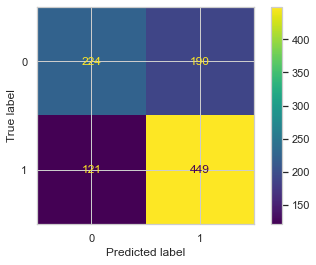

In [60]:
plot_confusion_matrix(best_lr_pipeline, X_test, y_test, values_format='d')

In [61]:
best_lr_pipeline[1].coef_

array([[ 0.18747875, -0.17670777,  0.73130102, -0.01070844,  0.09342208]])

## SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
std_scaller = [('numeric_scaler', SklearnTransformerWrapper(variables=['gf_rolling_ratio', 'ga_rolling_ratio', 'points_last_season_ratio',
       #'FIFA_23_Overall_ratio',
                                                                       'pont_rolling_ratio', 'last_2_results'], transformer=StandardScaler()))]

pipeline_svc = Pipeline(steps= std_scaller + [('svc', SVC())])

In [ ]:
pipeline_svc.fit(X_train, y_train)

In [ ]:
y_pred = pipeline_svc.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(pipeline_svc, X_test, y_test, values_format='d')

In [ ]:
parametros = {
    'svc__C': [0.01, 0.1, 1, 10], # [0.001, 0.01, 0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'], # ['scale', 'auto'],
    'svc__kernel': ['rbf', 'poly'], # ['rbf', 'poly', 'linear', 'sigmoid'],
    'svc__class_weight': ['balanced', None]
}
grid_search = GridSearchCV(pipeline_svc, parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

In [ ]:
best_svc_pipeline = Pipeline(steps= std_scaller + [('svc', SVC(C=0.1, class_weight=None, gamma='scale', kernel='rbf'))])

In [ ]:
best_svc_pipeline.fit(X_train, y_train)

In [ ]:
y_pred_best = best_svc_pipeline.predict(X_test)

In [ ]:
precision_score_svm = precision_score(y_test, y_pred_best)
accuracy_score_svm = accuracy_score(y_test, y_pred_best)
recall_score_svm = recall_score(y_test, y_pred_best)
f1_score_svm = f1_score(y_test, y_pred_best)
roc_auc_score_svm = roc_auc_score(y_test, y_pred_best)

In [ ]:
plot_confusion_matrix(best_svc_pipeline, X_test, y_test, values_format='d')

In [ ]:
accuracy_score_svm

In [ ]:
precision_score_svm

In [ ]:
recall_score_svm

In [ ]:
f1_score_svm

In [ ]:
roc_auc_score_svm

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(X_train, y_train)

In [ ]:
y_pred = dt.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
recall_score(y_test, y_pred)

In [ ]:
f1_score(y_test, y_pred)

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(dt, X_test, y_test, values_format='d')

In [ ]:
parametros = {
  'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'criterion': ['gini', 'entropy'],
  'class_weight': ['balanced', 'None'],
  'min_samples_split': [2, 3, 4, 5],
}

grid_search = GridSearchCV(DecisionTreeClassifier(), parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

In [ ]:
best_dt = DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4, min_samples_split=2)

In [ ]:
best_dt.fit(X_train, y_train)

In [ ]:
y_pred_best = best_dt.predict(X_test)

In [ ]:
precision_score_dt = precision_score(y_test, y_pred_best)
accuracy_score_dt = accuracy_score(y_test, y_pred_best)
recall_score_dt = recall_score(y_test, y_pred_best)
f1_score_dt = f1_score(y_test, y_pred_best)
roc_auc_score_dt = roc_auc_score(y_test, y_pred_best)

In [ ]:
plot_confusion_matrix(best_dt, X_test, y_test, values_format='d')

In [ ]:
precision_score_dt

In [ ]:
accuracy_score_dt

In [ ]:
recall_score_dt

In [ ]:
f1_score_dt

In [ ]:
roc_auc_score_dt

In [ ]:
from sklearn import tree

fig = plt.figure(figsize=(15,8))
_ = tree.plot_tree(best_dt, 
                   feature_names=X_train.columns,  
                   class_names=['0','1'],
                   filled=True)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(rf, X_test, y_test, values_format='d')

In [ ]:
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

parametros = {
    'max_depth': [2, 3, 4, 5, 6, 7], # 25, 30, None],
    'max_features': ['sqrt'], # 'sqrt', 'None'],
    'min_samples_split': [5, 10], # 5, 10, 15, 100],
    'min_samples_leaf': [2, 5], # 5, 10],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(RandomForestClassifier(), parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

In [ ]:
best_rf = RandomForestClassifier(class_weight= None, max_depth= 3, max_features= 'sqrt',
                                 min_samples_leaf= 2, min_samples_split= 10, n_estimators= 100, random_state=7)

In [ ]:
best_rf.fit(X_train, y_train)

In [ ]:
y_pred_best = best_rf.predict(X_test)

In [ ]:
    precision_score_rf = precision_score(y_test, y_pred_best)
    accuracy_score_rf = accuracy_score(y_test, y_pred_best)
    recall_score_rf = recall_score(y_test, y_pred_best)
    f1_score_rf = f1_score(y_test, y_pred_best)
    roc_auc_score_rf = roc_auc_score(y_test, y_pred_best)

In [ ]:
plot_confusion_matrix(best_rf, X_test, y_test, values_format='d')

In [ ]:
precision_score_rf

In [ ]:
accuracy_score_rf

In [ ]:
recall_score_rf

In [ ]:
f1_score_rf

In [ ]:
roc_auc_score_rf

## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier()

In [ ]:
xgb.fit(X_train, y_train)

In [ ]:
y_pred = xgb.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(xgb, X_test, y_test, values_format='d')

In [ ]:
parametros = {
    'learning_rate': [0.01, 0.1], #[0.1, 0.01, 0.015, 0.025, 0.05, 0.1],
    'n_estimators': [500], # [500, 1000, 2000, 5000, 10000],
    'max_depth': [3, 5, 9], # [3, 5, 7, 9, 12, 15, 17, 25],
    'colsample_bytree': [0.6, 0.8], # [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.6, 0.9], # [0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': ['balanced', None],
}

grid_search = GridSearchCV(XGBClassifier(), parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

In [ ]:
best_xgb = XGBClassifier(class_weight='balanced', colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.9)

In [ ]:
best_xgb.fit(X_train, y_train)

In [ ]:
y_pred_best = best_xgb.predict(X_test)

In [ ]:
precision_score_xgb = precision_score(y_test, y_pred_best)
accuracy_score_xgb = accuracy_score(y_test, y_pred_best)
recall_score_xgb = recall_score(y_test, y_pred_best)
f1_score_xgb = f1_score(y_test, y_pred_best)
roc_auc_score_xgb = roc_auc_score(y_test, y_pred_best)

In [ ]:
plot_confusion_matrix(best_xgb, X_test, y_test, values_format='d')

In [ ]:
accuracy_score_xgb

In [ ]:
precision_score_xgb

In [ ]:
recall_score_xgb

In [ ]:
f1_score_xgb

In [ ]:
roc_auc_score_xgb

## LGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgbm = LGBMClassifier()

In [ ]:
lgbm.fit(X_train, y_train)

In [ ]:
y_pred = lgbm.predict(X_test)

In [ ]:
precision_score(y_test, y_pred)

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
plot_confusion_matrix(lgbm, X_test, y_test, values_format='d')

In [ ]:
parametros = {
    'learning_rate': [0.01, 0.05], # [0.01, 0.015, 0.025, 0.05, 0.1],
    'n_estimators': [500], # [500, 1000, 2000, 5000, 10000],
    'max_depth': [3, 7, 9], # [3, 5, 7, 9, 12, 15, 17, 25],
    'colsample_bytree': [0.6], # [0.6, 0.7, 0.8, 0.9, 1.0],
    'subsample': [0.8], # [0.6, 0.7, 0.8, 0.9, 1.0],
    'class_weight': ['balanced', None],
}

grid_search = GridSearchCV(LGBMClassifier(), parametros, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print()
print('='*100)
print(grid_search.best_params_)
print('='*100)
print()

In [ ]:
best_lgbm = LGBMClassifier(class_weight=None, colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=500, subsample=0.8)

In [ ]:
best_lgbm.fit(X_train, y_train)

In [ ]:
y_pred_best = best_lgbm.predict(X_test)

In [ ]:
precision_score_lgbm = precision_score(y_test, y_pred_best)
accuracy_score_lgbm = accuracy_score(y_test, y_pred_best)
recall_score_lgbm = recall_score(y_test, y_pred_best)
f1_score_lgbm = f1_score(y_test, y_pred_best)
roc_auc_score_lgbm = roc_auc_score(y_test, y_pred_best)

In [ ]:
plot_confusion_matrix(best_lgbm, X_test, y_test, values_format='d')

In [ ]:
accuracy_score_lgbm

In [ ]:
precision_score_lgbm

In [ ]:
recall_score_lgbm

In [ ]:
f1_score_lgbm

In [ ]:
roc_auc_score_lgbm

###  Resumo das métricas de cada modelo


## Melhor modelo:

### Feature importance

In [ ]:
data = {'lr': [precision_score_lr, accuracy_score_lr, recall_score_lr, f1_score_lr, roc_auc_score_lr],
        'svm': [precision_score_svm, accuracy_score_svm, recall_score_svm, f1_score_svm, roc_auc_score_svm],
        'dt': [precision_score_dt, accuracy_score_dt, recall_score_dt, f1_score_dt, roc_auc_score_dt],
        'rf': [precision_score_rf, accuracy_score_rf, recall_score_rf, f1_score_rf, roc_auc_score_rf],
        'xgb': [precision_score_xgb, accuracy_score_xgb, recall_score_xgb, f1_score_xgb, roc_auc_score_xgb],
        'lgbm': [precision_score_lgbm, accuracy_score_lgbm, recall_score_lgbm, f1_score_lgbm, roc_auc_score_lgbm]}

In [ ]:
df_models = pd.DataFrame.from_dict(data, orient='index', columns=['precision', 'accuracy', 'recall', 'f1', 'roc_auc']).round(2)

In [ ]:
df_models

Todos os modelos testados possuem métricas de avaliação muito semelhantes. Como o modelo de **regressão linear** é o mais fácil de ser entendido e explicado, e também possui a maior precisão, esse será o modelo final escolhido.

## Verificando os pesos que o modelo atribuiu para cada variável

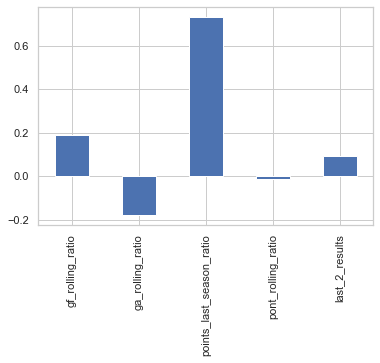

In [62]:
# Get the coefficients for each feature
coefs = pd.Series(best_lr_pipeline[1].coef_[0], index=X.columns)

# Plot the coefficients
coefs.plot(kind='bar')
plt.show()

In [63]:
best_lr_pipeline

Pipeline(steps=[('numeric_scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['gf_rolling_ratio',
                                                      'ga_rolling_ratio',
                                                      'points_last_season_ratio',
                                                      'pont_rolling_ratio',
                                                      'last_2_results'])),
                ('logit', LogisticRegression(C=1))])

In [64]:
# salvando o modelo de ML
import joblib

joblib.dump(best_lr_pipeline, "best_lr.pkl")

['best_lr.pkl']